### Steps to Take
- Break ~30 min data into sets of at least 10 seconds
- Run fft on those 10 seconds with a window
- Find frequency peaks using some percentage of the max peak
- Run fft on entire ambient noise dataset and find peaks
- Rearrange the list so that the highest amplitude shows up first
- Deep learning input will be input noise and ambient noise
- Deep learning will classify noise as being not faulty to faulty on a scale from 0 to 1

### Importing Libraries

In [15]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

### Importing Datasets

In [4]:
ambient_df = pd.read_csv('data/AmbientNoiseData.csv')
ambient_mic_data = ambient_df['Volt']
normal_df = pd.read_csv('data/NormalMotorON.csv')
normal_mic_data = normal_df['Volt']
faulty_df = pd.read_csv('data/FaultyMotorON.csv')
faulty_mic_data = faulty_df['Volt']

faulty_df_1 = pd.read_csv('data/ImbalanceMotorON_1.csv')
faulty_mic_data_1 = faulty_df_1['Volt0']
normal_df_1 = pd.read_csv('data/NormalMotorON_1.csv')
normal_mic_data_1 = normal_df_1['Volt0']
ambient_df_1 = pd.read_csv('data/NormalMotorOFF_1.csv')
ambient_mic_data_1 = ambient_df_1['Volt0']

### Variables Setup & Functions

In [5]:
sr = 40000
max_freq = 5000
peak_detail = 0.03
kaiser_beta = 10
data_interval = 5 # in seconds
ambient_feature_size = 8
motor_feature_size = 8

sr_1 = 30000

def get_fft_peaks(data_input, sorted_ambient_pf, type = None):
    data_output = []
    for i in range(0, data_input.shape[0]):
        mic_data_segment = data_input[i]
        segment_window = np.kaiser(len(mic_data_segment), kaiser_beta)
        windowed_mic_data_segment = np.multiply(mic_data_segment, segment_window)
        segment_fft_result = np.fft.rfft(windowed_mic_data_segment)
        segment_freq = np.fft.rfftfreq(len(windowed_mic_data_segment), d=1/sr)
        segment_magnitude = np.abs(segment_fft_result)
        segment_max_freq_indices = np.where(segment_freq <= max_freq)
        short_segment_freq = segment_freq[segment_max_freq_indices]
        short_segment_magnitude = segment_magnitude[segment_max_freq_indices]
        segment_peaks, _ = find_peaks(short_segment_magnitude, prominence=np.max(short_segment_magnitude)*peak_detail)
        segment_peaks_freq = short_segment_freq[segment_peaks]
        segment_peaks_magnitude = short_segment_magnitude[segment_peaks]
        sorted_pairs = sorted(zip(segment_peaks_magnitude, segment_peaks_freq), reverse=True)
        sorted_peaks_freq = [item[1] for item in sorted_pairs]
        # normalize the data
        sorted_peaks_freq = [x/max_freq for x in sorted_peaks_freq]
        if len(sorted_peaks_freq) > motor_feature_size:
            sorted_peaks_freq = sorted_peaks_freq[:motor_feature_size]
        elif len(sorted_peaks_freq) < motor_feature_size:
            sorted_peaks_freq.extend([0] * (motor_feature_size-len(sorted_peaks_freq)))
        combined_peaks_freq = sorted_peaks_freq + sorted_ambient_pf
        if type == 'normal':
            combined_peaks_freq.append(0)
        elif type == 'faulty':
            combined_peaks_freq.append(1)
        # normal motor corresponds to 0 in this model
        data_output.append(combined_peaks_freq)
    return np.array(data_output)


def get_ambient_fft_peaks(a_mic_data, sampling_rate):
    ambient_size = a_mic_data.size
    ambient_window = np.kaiser(ambient_size, kaiser_beta)
    windowed_ambient_mic_data = np.multiply(a_mic_data, ambient_window)
    ambient_fft_result = np.fft.rfft(windowed_ambient_mic_data) # no need to normalize because magnitude values are not being used
    ambient_freq = np.fft.rfftfreq(ambient_size, d=1/sampling_rate)
    ambient_magnitude = np.abs(ambient_fft_result)
    ambient_max_freq_indices = np.where(ambient_freq <= max_freq)
    short_ambient_freq = ambient_freq[ambient_max_freq_indices]
    short_ambient_magnitude = ambient_magnitude[ambient_max_freq_indices]

    ambient_peaks, _ = find_peaks(short_ambient_magnitude, prominence=np.max(short_ambient_magnitude)*peak_detail)
    ambient_peaks_freq = short_ambient_freq[ambient_peaks]
    ambient_peaks_magnitude = short_ambient_magnitude[ambient_peaks]
    sorted_ambient_pairs = sorted(zip(ambient_peaks_magnitude, ambient_peaks_freq))
    sorted_ambient_peaks_freq = [item[1] for item in sorted_ambient_pairs]
    if len(sorted_ambient_peaks_freq) > ambient_feature_size:
        sorted_ambient_peaks_freq = sorted_ambient_peaks_freq[:ambient_feature_size]
    elif len(sorted_ambient_peaks_freq) < ambient_feature_size:
        sorted_ambient_peaks_freq.extend([0]*(ambient_feature_size - len(sorted_ambient_peaks_freq)))
    sorted_ambient_peaks_freq = [x/max_freq for x in sorted_ambient_peaks_freq]
    return sorted_ambient_peaks_freq

def split_in_intervals(mic_data, sampling_rate):
    mic_data_size = mic_data.size
    interval = sampling_rate*data_interval
    remainder = mic_data_size % interval
    num_intervals = mic_data_size//interval
    split_mic_data = np.array(np.split(mic_data.iloc[:mic_data_size-remainder], num_intervals))
    return split_mic_data   

### Ambient Noise FFT and Peaks

### Ambient Noise Peaks

In [6]:
sorted_ambient_peaks_freq = get_ambient_fft_peaks(ambient_mic_data, sr)
sorted_ambient_peaks_freq_1 = get_ambient_fft_peaks(ambient_mic_data_1, sr_1)

### Splitting Data into Intervals

In [7]:
normal_split_mic_data = split_in_intervals(normal_mic_data, sr)
faulty_split_mic_data = split_in_intervals(faulty_mic_data, sr)

normal_split_mic_data_1 = split_in_intervals(normal_mic_data_1, sr_1)
faulty_split_mic_data_1 = split_in_intervals(faulty_mic_data_1, sr_1)

c:\Users\rarora\DataspellProjects\PredictiveAnalysis\venv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


### Intervals Train-Test Split

In [8]:
normal_data_train, normal_data_test = train_test_split(normal_split_mic_data, test_size=0.2)
faulty_data_train, faulty_data_test = train_test_split(faulty_split_mic_data, test_size=0.2)

normal_data_train_1, normal_data_test_1 = train_test_split(normal_split_mic_data_1, test_size=0.2)
faulty_data_train_1, faulty_data_test_1 = train_test_split(faulty_split_mic_data_1, test_size=0.2)

### FFT and Peaks for Training Data

In [9]:
normal_train_fft_peaks = get_fft_peaks(normal_data_train, sorted_ambient_peaks_freq ,'normal')
faulty_train_fft_peaks = get_fft_peaks(faulty_data_train, sorted_ambient_peaks_freq, 'faulty')


normal_train_fft_peaks_1 = get_fft_peaks(normal_data_train_1, sorted_ambient_peaks_freq_1, 'normal')
faulty_train_fft_peaks_1 = get_fft_peaks(faulty_data_train_1, sorted_ambient_peaks_freq_1, 'faulty')

### Combining to Get Full Training Dataset

In [10]:
training_set = np.concatenate(
    (
        normal_train_fft_peaks, 
        faulty_train_fft_peaks, 
        normal_train_fft_peaks_1, 
        faulty_train_fft_peaks_1,
    ), 
    axis=0)
rand = np.random.default_rng(200)
rand.shuffle(training_set)
x_train = training_set[:, :-1]
y_train = training_set[:, -1]

### FFT for Testing Dataset

In [11]:
normal_test_fft_peaks = get_fft_peaks(normal_data_test, sorted_ambient_peaks_freq ,'normal')
faulty_test_fft_peaks = get_fft_peaks(faulty_data_test, sorted_ambient_peaks_freq, 'faulty')

normal_test_fft_peaks_1 = get_fft_peaks(normal_data_test_1, sorted_ambient_peaks_freq_1, 'normal')
faulty_test_fft_peaks_1 = get_fft_peaks(faulty_data_test_1, sorted_ambient_peaks_freq_1, 'faulty')

### Combining to get Full Testing Dataset

In [12]:
testing_set = np.concatenate(
    (
        normal_test_fft_peaks, 
        faulty_test_fft_peaks, 
        normal_test_fft_peaks_1, 
        faulty_test_fft_peaks_1,
    ), 
    axis=0)
rand = np.random.default_rng(200)
rand.shuffle(testing_set)
x_test = testing_set[:, :-1]
y_test = testing_set[:, -1]

### Training the Model

In [22]:
model = keras.Sequential(
    [
        keras.Input(shape=((ambient_feature_size+motor_feature_size),)),
        layers.Dense(5, activation='relu'),
        layers.Dense(5, activation='relu'),
        layers.Dense(1, activation='sigmoid'),
    ]
)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'],
    loss = 'binary_crossentropy',
)
history = model.fit(x_train, y_train, epochs=100, verbose=1, validation_data=(x_test, y_test))

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5000 - loss: 0.6921 - val_accuracy: 0.6021 - val_loss: 0.6902
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5796 - loss: 0.6895 - val_accuracy: 0.6021 - val_loss: 0.6887
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5859 - loss: 0.6881 - val_accuracy: 0.5986 - val_loss: 0.6868
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6102 - loss: 0.6862 - val_accuracy: 0.5986 - val_loss: 0.6844
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6026 - loss: 0.6849 - val_accuracy: 0.6055 - val_loss: 0.6816
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6023 - loss: 0.6802 - val_accuracy: 0.6159 - val_loss: 0.6779
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6320 - loss: 0.6764 - val_accuracy: 0.6159 - val_loss: 0.6739
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6397 - loss: 0.6728 - val_accuracy: 0.6436 - v

### Visualizing Output

In [23]:
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - accuracy: 0.7277 - loss: 0.4481
test loss, test acc: [0.424679696559906, 0.7474048733711243]


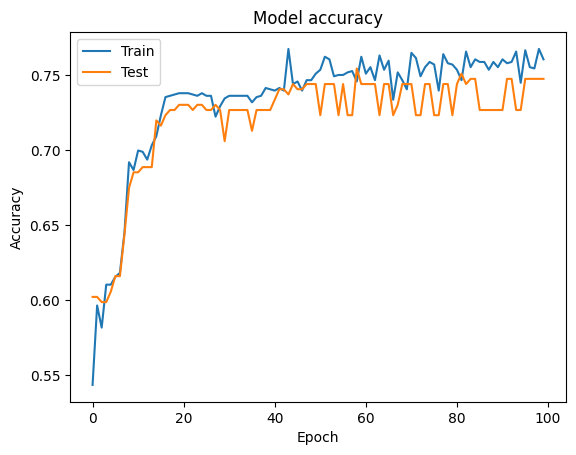

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

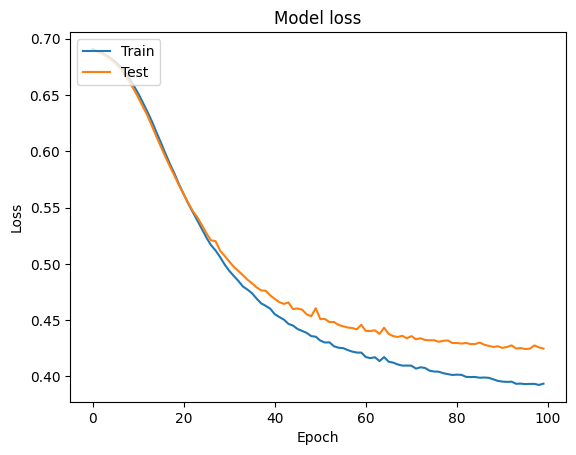

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()